In [394]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import random
import scipy.misc
from functools import reduce
%matplotlib inline

Defining the path to the image files

In [512]:
root = os.getcwd()
train_path = os.path.join(root,'train_sub')
print(train_path)
test_path = os.path.join(root, 'test_sub')

/Users/jas/Documents/Python_Workspace/DeepLearning/Neural_Nets_from_scratch/train_sub


We will need to resize our images so as to make them uniform in size.

In [570]:
pic_height = 50
pic_width = 50

Now, let's resize the image to the above set values and flatten the resulting array to have a size (3* pic_height*pic_width, 1). We then append that to a larger array which forms the training set.

In [571]:
def get_dataset(path):
    for root, dirs, fils in os.walk(path):
        X = []
        Y = []
        n = len(fils)
        print('{} files in directory'.format(n))
        for fil in fils:
            if fil[0]=='.':
                pass
            else:
                pic = Image.open(os.path.join(root,fil))
        #         print(pic.size)
                pic_resized = scipy.misc.imresize(pic, (pic_height, pic_width)).flatten()
                X.append(pic_resized)

                animal = fil.split('.')[0]
                if animal == 'cat':
                    y = 1
                elif animal == 'dog':
                    y = 0
                else:
                    raise ValueError('No value given for animal')
                Y.append(y)

    X = np.array(X).reshape(n, -1)
    Y = np.array(Y).reshape(n, -1)
    return X, Y, n

In [572]:
X_train, Y_train, n_train = get_dataset(train_path)
X_test, Y_test, n_test = get_dataset(test_path)

1044 files in directory


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


104 files in directory


In [573]:
def show_image(X, Y):
    i = random.randint(1,len(Y))
    if Y[i]==1:
        print('cat')
    else:
        print('dog')
    data = X[i].reshape(pic_height, pic_width, 3)
    img = Image.fromarray(data, 'RGB')
    imshow(img)

cat


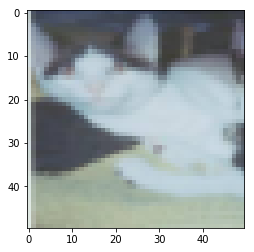

In [574]:
show_image(X_test, Y_test)

The training set, which is in the form of a list of lists can now be converted to an array and reshaped to give us a (n_ex, 3* pic_height*pic_width) size array

Now we will center and normalize the pixels so as to make it centered around the origin and more gaussian like. Since the relative scales of pixels are normally in the 0-255 range in images, it may not be required to perform this step.

In [575]:
def normalize(X, mean=True, std=True):
    X = X.astype('float64')
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    return np.array(X)

In [576]:
X_train = normalize(X_train)
X_test = normalize(X_test)

Now let us get to the part where we will begin to create our Neural Network. The first thing we need to create is the neurons, each of which is associated with a weight and a bias, which are the parameters that the neural network will learn and optimize over the course of its learning. Let us first initialize these parameters. To do that, we need to know how many layers of neurons our network contains and the number of neurons in each layer.

Let us take the simplest case of a neural network with 1 hidden layer, 1 input and 1 output layer. 

**Input Layer**

The number of neurons in the input layer are unique determined by the number of features in the training data.

**Output Layer**

If the NN is solving a regression problem, then the output layer has a single node. Otherwise if the NN is solving a classificiation problem, then it also has a single node unless softmax is used in which case the output layer has one node per class label. 

**Hidden Layer**

The number of neurons in the hidden layer need to be input. One can look at previous [analysis](http://www.chioka.in/how-does-the-number-of-hidden-neurons-affect-a-neural-networks-performance/) which show that while too few neurons limit the ability of the neural network to learn enough, too many neurons do not add much to the learning ability of the network while resulting in overfitting by effectively turning into a memory bank and also extending the training time. A common rule of law usually abided is *the optimal size of the hidden layer is usually between the size of the input and size of the output layers*.

**Number of Layers**

Given that here we are trying to display an instance of a simple one hidden layer neural network, we will try to classify the dataset using just one. However the number of layers should be determined by the nature of the classification problem. A linearly separable dataset would not need a hidden layer at all, while one hidden layer suffises for most of the remaining problems. According to Jeff Heaton in "Introduction to Neural Networks for Java, Second Edition":

"*0 - Only capable of representing linear separable functions or decisions.*

*1 - Can approximate any function that contains a continuous mapping
from one finite space to another.*

*2 - Can represent an arbitrary decision boundary to arbitrary accuracy
with rational activation functions and can approximate any smooth
mapping to any accuracy.*"

In [577]:
def layer_sizes(X, Y, n_h):
    
    n_x = X.shape[1]
    n_h = n_h
    n_y = Y.shape[1]
    
    return n_x, n_h, n_y

In [578]:
n_x, n_h, n_y = layer_sizes(X_train, Y_train, 10)

In [579]:
def initialize_params(n_x, n_h, n_y):
    
    W1 = np.random.rand(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.rand(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2
             }
    return params

In [605]:
params = initialize_params(n_x, n_h, n_y)

Next we would like to set the learning into motion, which involves performing the following computations iteratively until the loss falls below a certain threshold or for a fixed number of iterations. The steps are

- Forward propoagation
- Calculate Loss
- Backward Propagation
- Parameter Update

Let us write functions to evaluate each of these steps.

###Activation Functions

There are several types of activation functions that can be used in a neural network, and we can use different activation functions for different neurons/layers within the neural network. In this case, we will use the simplest type of activation function, the sigmoid function.

In [581]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [582]:
def forward_propagation(params, X):
    
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    Z1 = np.dot(W1,X.T) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    
    activations = {'Z1': Z1,
                   'A1': A1,
                   'Z2': Z2,
                   'A2': A2
                    }
    return activations

In [583]:
acts = forward_propagation(params, X_train)

In [584]:
def loss(A2, X, Y):
    
    m = Y.shape[0]
    cost = -(np.dot(np.log(A2), Y) + np.dot(np.log(1-A2), 1-Y))/m
    cost = cost.sum()
    return np.squeeze(cost)

In [585]:
cost = loss(acts['A2'], Y_train, X_train)
print(cost)

5230.91626493


In [586]:
def backward_propagation(params, activations, X, Y):
    
    m = Y.shape[1]
    
    W1 = params['W1']
    W2 = params['W2']
    
    A1 = activations['A1']
    A2 = activations['A2']
    
    dZ2 = A2-Y.T
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    dZ1 = np.dot(W2.T,dZ2)*(1-np.power(A1,2))
    dW1 = np.dot(dZ1,X)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [587]:
grads = backward_propagation(params, acts, X_train, Y_train)

In [588]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    
    W1 = parameters['W1']-learning_rate*grads['dW1']
    b1 = parameters['b1']-learning_rate*grads['db1']
    W2 = parameters['W2']-learning_rate*grads['dW2']
    b2 = parameters['b2']-learning_rate*grads['db2']
    
    params = {'W1': W1,
              'b1': b1,
              'W2': W2,
              'b2': b2
    }
    return params

In [589]:
params = update_parameters(params, grads, learning_rate = 1.2)

Let us also define the predict function which uses the parameters for the minimized loss to evaluate the labels for the test cases.

In [590]:
def predict(params, X):
    A1 = sigmoid(np.dot(params['W1'],X.T) + params['b1'])
    A2 = sigmoid(np.dot(params['W2'],A1) + params['b2'])
    return A2

def accuracy(preds, Y):
    return reduce((lambda s, e: s + int(e)), preds == Y) / len(Y)

Now that we have defined all necessary functions, we can implement our neural network which will call all these functions iteratively a certain number of times.

In [596]:
def nn_model(X, Y, n_h, num_iterations=10, alpha=0.001, print_cost=False):
    
    #get_layer_sizes
    n_x, n_h, n_y = layer_sizes(X, Y, n_h)
    
    #initialize parameters
    params = initialize_params(n_x, n_h, n_y)
 
    #Defining cost_list to store costs over iterations
    cost_list = []
    
    for i in range(num_iterations):
        #forward propagation
        activations = forward_propagation(params, X)

        #cost
        cost = loss(activations['A2'], X, Y)
        cost_list.append(cost)
        if print_cost==True and i % 200 == 0:
            print(cost)

        #backward propagation
        grads = backward_propagation(params, activations, X, Y)

        #parameter update
        params = update_parameters(params, grads, learning_rate = alpha)
        
    #Make predictions
    train_preds = predict(params, X_train)
    pred_labels_train = [1 if x>0.5 else 0 for x in train_preds.flatten()]
    print('training accuracy: {}'.format(accuracy(pred_labels_train,Y_train.flatten())))
    
    test_preds = predict(params, X_test)
    pred_labels_test = [1 if x>0.5 else 0 for x in test_preds.flatten()]
    print('test accuracy: {}'.format(accuracy(pred_labels_test,Y_test.flatten())))
    
    d = {"costs": cost_list,
         "Y_prediction_test": test_preds, 
         "Y_prediction_train" : train_preds, 
         "learning_rate" : alpha,
         "num_iterations": num_iterations}
    
    return params, d

In [597]:
parameters_final, d = nn_model(X_train, Y_train, n_h=150, num_iterations=3000, alpha=0.0001, print_cost=True)

0.709732811219
0.661283798386
0.627074546058
0.613097249339
0.608362726518


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


0.602759683228
0.596587844717
0.592242173102
0.58812863627
0.583973676393
0.581881911299
0.578689828534
0.5821632446
0.578165767259
0.579929769128
training accuracy: 0.6666666666666666
test accuracy: 0.5769230769230769


Plotting the cost curve, we see that with increasing iterations it gets harder and harder to further reduce the cost.

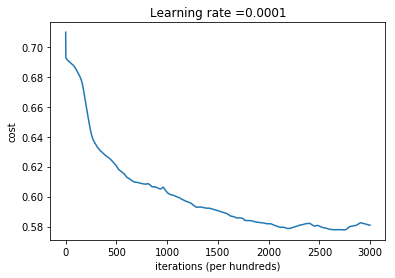

In [604]:
costs = np.squeeze(d['costs'])
plt.plot(range(d['num_iterations']), costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

###Analysis of results and possible improvements

Despite the abyssymal error rates, it is quite impressive that with just rudimentary normalization followed by a neural network with one hidden layer, we are able to have a model that can differentiate between images of dogs and cats in a varied set of environments. There are scores of steps we can take from this point to improve performance.

Without throwing away current model:
 - Tweak model hyperparameters of number of neurons in the hidden layer, learning rate, number of iterations
 - Use a different type of activation function
 - Pruning
While increasing the number of neurons in the hidden layer can inc
 
Data Preprocessing
 - Treat image with PCA and Whitening

Model Improvements 
 - Introduce regularization
 - Introduce additional hidden layers